<img align="left" width="20%" style="padding-right:10px;" src="Images/Ccom.png">

# On Tides and Tidal Analysis



### Adapted by Semme J. Dijkstra from a Lab by Andy Armstrong and Jim Irish 2020

v2.0.0: Semme J. Dijkstra: Complete overhaul for more logical flow and simpler explanations

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from numpy.fft import fft, fftfreq
import matplotlib.pyplot as plt
from numpy import pi, cos, sin
from datetime import datetime, date, timedelta
from utide import solve, reconstruct
import matplotlib.dates as mdates
import utide
import sys
import os
from pathlib import Path

sys.path.append(os.getcwd())
tide_path=os.path.abspath(os.path.curdir)+"/mydata/"

sys.path.append(str(tide_path)) # add the folder to the list of paths 
# print(sys.path)
# from mycode.specter import specter

print('This notebook uses UTide version'+utide.__version__)

This notebook uses UTide version0.3.0


# Water Levels and Tidal Analysis Using Two Tide Gauges

In this `Notebook` data is taken from two gauges that measure water levels by measuring pressure. A short introduction on the principle of such measurements is given, followed by a short introduction to tidal analysis. You will do some analysis using both **Fourier Transforms**, in particular **Fast Fourier Transforms (FFT)**., and the Least 

If you want to learn more in depth about tides you may consult the book [NOAA Special Publication NOS CO-OPS 3](Documents/Tidal_Analysis_and_Predictions.pdf) as it is an excellent resource.

___
# Bottom Pressure Measurement

In the case where the ocean is in approximate static equilibrium, the vertical equation of motion becomes the hydrostatic equation, and this can be integrated from the top of the atmosphere ($\infty$) to the bottom of the ocean ($-h$) to obtain the pressure observed by the instrument deployed there. 

$$P_{-h}(t)=\int_{-h}^{\infty} \rho(z,t) \cdot g \cdot dz$$

We can break this up into several pieces as follows:

$$P_{-h}(t)=\int_{\eta}^{\infty} \rho_{atm}(z,t) \cdot g \cdot dz + 
            \int_{0}^{\eta} \rho_{0}(z,t) \cdot g \cdot dz + 
            \int_{-h}^{0} \rho_{avg}(z,t) \cdot g \cdot dz +
            \int_{-h}^{0} \rho'(z,t) \cdot g \cdot dz$$
            
The integral from the top of the atmosphere ($z=\infty$) to the sea surface ($z=\eta$) is just the atmospheric pressure, $P_{atm}$. 

The sea surface is generally not smooth, but consists of waves whose elevation we describe by $\eta$ as a function of time.  Thus the next term is the integral from the sea surface ($z=\eta$) to the mean sea level ($z=0$).  This then is a pressure due to the surface waves that we approximate as the surface density, $\rho_0$, times the elevation $\eta$.  However, remember that surface wave effects decrease with depth as $e^{-k\cdot z}$ where $k$ is the surface wave wavenumber ($k = 2\pi/\lambda$) and $z$ the depth.

The next term involves the integral from the mean sea level ($z=0$) to the sea floor ($z=-h$).  We shall break this further up into terms depending on the density.  The first is the average density, $\rho_{avg}$, times the mean depth $-h$ and is just the mean hydrostatic pressure seen by the bottom pressure sensor.

The final term is the deviation from the mean density where
			 $$\rho(z) = \rho_{avg} + \rho’(z,t)$$
             
where the perturbation density $\rho’$ contains the effects of internal density changes on the bottom pressure. 



We may now write the pressure our bottom instrument sees as the contribution of these terms:

$$P_{-h}(t)=P_{atm}(t)+\rho_0(t)\cdot g \cdot\eta (t) + \rho_{avg}\cdot g \cdot h + \int_{-h}^{0} \rho'(z,t) \cdot g \cdot dz$$
            
So we see the signal we see at the bottom is due to: 
- the atmospheric pressure
- the contribution due to the waves and other deviations of the sea level from its mean position
- the average hydrostatic pressure due to the depth of the water
- the contribution due to internal density changes.  Which in shallow water situations is small


Solving for the time varying sea level variation, $\eta(t)$, as a function of the time varying density:

$$\eta(t) = \frac{\{P_{-h}(t) - P_{atm}(t)\}}{\rho_0(t)\cdot g} - constant$$
            
The term in curly brackets is the differential pressure that tide gauge at Jackson Lab measures.  This can also be calculated from an absolute pressure sensor and a nearby atmospheric pressure sensor

The correction $\rho_0(t)\cdot g$ is a time varying term and should be measured.


# $\rho(t)\cdot g$ Correction from MicroCAT at Jackson Estuarine Lab

<img align="left" width="70%" style="padding-right:10px;" src="Images/density_gravity_corrn.png">

___
# Sine Wave

A sine wave is a continuous smooth periodic oscillation. Sine waves occur in tidal motion due to the periodic motion of the Earth and astronomical bodies. In tides we tend to use the $1/2 \pi$ complement to the sine, known as the cosine

$$\eta(t) = A\cdot cos(f\cdot t + \theta)$$


where:

- A: amplitude
- f: frequency or the cycles per second
- $\theta$:  phase of cycle at $t=0$

___
# 0 Line Spectra

In the top plot generated by the code cell below you see a 1024 point sine wave signal with a 43 point cycle. The power spectrum of that signal is given by the bottom plot. In this case you might expect a single peak at exactly $f=1/43\approx0.023$, however this is not the case, which is due to the limitations of the fft algorithm that relies on the system being continuous.

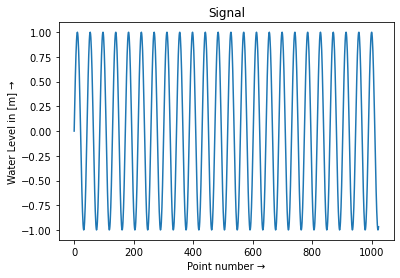

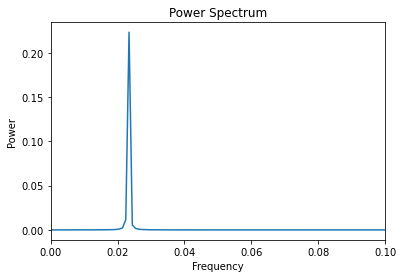

In [2]:
plt.figure();

n = 1024
s = int(n/2)
t = np.arange(n)
f = 1/43
A = 1
eta = A*sin(2*pi*f*t)  # Create a sinusoid
plt.plot(eta)
plt.title('Signal')
plt.ylabel('Water Level in [m] →') 
plt.xlabel('Point number →') 
plt.show()
plt.figure();     # Show the sinusoid
Fk = fft(eta)/n   # The FFT of the signal
nu = fftfreq(n,1) # The natural frequencies in the spectrum
plt.plot(nu[0:s],np.absolute(Fk[0:s])**2) # Plot the power spectrum
plt.title('Power Spectrum')
plt.ylabel('Power')
plt.xlabel('Frequency')
plt.xlim(0,0.1)
plt.show()


In the code cell above change the length of record by changing the number of samples and observe what happens to the signal and its spectrum; at the hand of your results answer the following question:

    - q_0_0: How does increasing the number of samples help improve the quality of the transform.

Increasing the number of samples by increasing the sampling rate also leads to similar effect i.e., the number of samples that determines the achievable quality of the FFT. Besides the answer to the question above, the following are effects of changing the sampling rate and duration.

- 1. Lengthening the record lowers the influence of transient and random noise
- 2. Increasing the sampling rate increases the Nyquist frequency, thus the ability to resolve high frequencies

In [3]:
# 0 Line Spectra
q_0_0 = 'Increasing the number of samples improves the quality of the transform through increasing the ...'

___
# Astronomical Frequencies

The tide generating forces are cyclical forces due to gravity acceleration of various astronomical processes. For tidal modeling there are 6 associated frequencies of particular importance 

$f_1$ = 1 cycle per lunar day = earth rotation (high moon to high moon) = 24.84 hours = 14.4921º/hr<br>
$f_2$ = 1 cycle per month = moon around earth = 27.3216 mean solar days = 0.544º/hr<br>
$f_3$ = 1 cycle per year = earth around sun = 365.2422 mean solar days = 0.0411º/hr<br>
$f_4$ = 1 cycle per 8.85 Julian years (365.25 days) = lunar perigee<br>
$f_5$ = 1 cycle per 18.61 Julian years = regression of the nodes<br>
$f_6$ = 1 cycle per 20,900 years = solar perigee<br>

___
# Tidal Frequencies

To determine the tidal elevation $\eta(t)$ we may use the expression:

$$\eta(t) = \Sigma_k\cdot A_k\cdot cos(f_k\cdot t + \theta_k)$$


where:

- $A_k$: amplitude of tidal constituent $k$
- $f_k$: frequency of tidal constituent $k$
- $\theta_k$:  phase of tidal constituent $k$

The tidal frequencies $f_k$ are combinations of the basic astronomical frequencies

___
# Darwin Symbol

Darwin symbols are shortcuts to identifying a tidal frequencies e.g., $M1, O1, K1, N2, M2, S2, M4$.

The principle tidal frequencies are identified by their Darwin Symbol which is related to the daily, monthly and yearly tides.

The 8 and 18 year tides are  handled separately as will be discussed later. 

The number in a Darwin Symbol represents the species, or the number of cycles per day of that constituent.  

___
# A Word on the Tidal Phases

In the discussion of the determination of the tidal frequencies from the tidal equation the phase $\theta_k$ and amplitude $A_k$ at each constituent were used. You have to use care with the phase term $\theta_k$ as it is dependent on the time reference frame used

- $G$ = Greenwich Epoch = phase lag of the observed tide behind the passage of the sun or moon over Greenwich Meridian with time kept in UTC.  
- $g$ = same as $G$ but uses local time rather than UTC.
- $\kappa$ = local Epoch = phase lag of the observed tide behind the passage of the sun or moon over the local meridian.
    - Where $G = k + s\cdot$*local West longitude*<br>
      $s$ = species with 0 for long period, 1 for diurnal, 2 for semi-diurnal, etc.  
      
**For plotting the spatial structure of the tide, you want the Greenwich Epoch (G) rather than the local epoch!**



___
# Spectrum of Tidal Constituents (AKA Tide Lines)

<img align="left" width="70%" style="padding-right:10px;" src="Images/Hartman-and-Wenzel_tidal_spectrum.png">

Source: Hartmann T. and Wenzel H.G., 1995, The HW95 tidal potential
catalogue. Geophys. Res. Lett, 22, 3553–3556.

Note that it may be seen that many of the constituents are clustered in terms of frequency. This presents difficulty in their analysis as there may be significant correlation in the analysis of amplitudes and phases of different frequencies within such a cluster. It is therefore useful to calculate the correlation in the solution of the coefficients in the analysis. The method of the least squares inherently allows for the determination of such correlations, making it a suitable tool for the estimation of the constituent parameters.

# Additional Considerations

## Tides of the solid earth.  

The surface of the earth rises and falls up to 30 cm due to the forcing of the sun and moon.  The earth tides are generally in equilibrium with the tidal potential. The Love numbers describe the elasticity of the earth in response to the gravitational forcing.  

## Tides of the solid moon

seismometers on the moon show that there are “moon” tides due to the gravitational attraction of the sun.

___
# Tidal Analysis Methods

To do tidal analysis there are two basic approaches

- 1 Harmonic Method – NOAA/NOS Original Method

    - Fourier Transform at tidal frequencies
    - Requires 1 month or 1 year records with no gaps.
<br><br>
- 2 Least Squares – UTide
    Fits predicted tide to observed in least squares sense
    - Records may have gaps
    - Any length record, but longer than 1 year.
    - Uncertainty of the estimated amplitude and phase for each constituent are provided
    - appropriate constituents are automatically selected as a results of the analysis of covariances (correlations)

### Relative Performance
For very long, “clean” records, the results from these methods are statistically the same. It may be argued that the least squares method is preferable for longer duration series (>1 year) due to being less sensitive to problems and or gaps in the input data, as well as the ability to robustly estimate the uncertainties associated to the constituents.

# Analysis Methods 1 Harmonic Method – NOAA/NOS

- First tidal analysis was a Fourier transform at tidal frequencies given by astronomy - done by hand. No need for a full transform. 
- The transform gives phase relative to the record start and it needs to be adjusted relative to astronomy.     
- NOAA normally uses 1 month or 1 year record lengths to get around windowing problems.

## Nodal Correction

Analysis on less than one year of data can not resolve 8 and 18.6 year effects. 
Therefore, use Darwin Symbols like M2 to “name” the frequency, and adjust the amplitude and phase of a one year record for the 8 and 18.6 yr tides by:
      $$\eta(t) = \Sigma a_k\cdot A_k\cdot cos(f_k t + \theta_k+ b_k)$$
      
Where $a_k$ and $b_k$ are “nodal” corrections in amplitude and phase for a record < 1 year at the midpoint of the record.

- Analysis is by Fourier transform at the tidal frequency.  The frequency is determined quite accurately by astronomy 
    - M2 = 1.93227361 Cycles Per Day (`cpd`)
- Analysis is done on the largest of the constituents as determined by equilibrium theory (e.g. M2 = 0.90812, and O1 = 0.37689).
- NOAA uses 25 constituents (including higher harmonics e.g. M4, M6) to make a normal analysis. (Other routines use up to 49 constituents.)   
- For short records (e.g. 1 month), 5 constituents are analyzed and the rest of the constituents (up to 49) are inferred from equilibrium theory. 
- The analysis selects the part of the signal which is in constant amplitude and phase relation with the observed at a constituent's frequency.

___
## Nodal Correction

The crux of tidal analysis is how to analyze for the tidal part of the water level signal without including “noise.”
There is “noise” in all geophysical data, so any analysis must consider how to separate the tidal signal from the background noise i.e., determine the Signal to Noise Ratio (`SNR`).

For a good prediction, you do not want to predict all the variance (non tidal energy) in the record, but just the tidal part. In this method removing the noise from the data is done by using the coefficients to 'predict' the tides for the duration of observations and adjust them until an optimal match is found. This effectively addresses some of the limitations associated to discrete Fourier Transforms. 

___
# Prediction

Once you have analyzed a record for the harmonic constants (e.g., M2  0.389 m  006.1º) you can predict the tide for any other time for that place. It is important that you understand that classical tidal analysis and prediction are only valid for only one point in space i.e., the location at which the observations were made.

Before the advent of modern digital computers prediction was done using a tide generating machine. Tide generating machines are mechanical devices.



In [36]:
from ipywidgets import Video
Video.from_file(os.path.join(os.getcwd(), "Images", "tide_prediction_machine_video.m4v"), width=400, height=400)
 

Video(value=b'\x00\x00\x00\x18ftypisom\x00\x00\x00\x00mp41avc1\x00\x00\x17)moov\x00\x00\x00lmvhd\x00\x00\x00\x…

<img align="left" width="30%" style="padding-right:10px;" src="Images/tide_prediction_machine.png">


If you have not done so already execute the code in the code cell above. As you can see the length of the arm $K_i$ determines the radius of a circle that each arm traverses. The position of each arm $K_i$ may be described by its angle, which is the phase angle of the associated tidal constituent. The rotational rate of each arm then determines the frequency or period. Thus to predict the tide using 7 components (like in the animation) you will need rotating arms $K_i, i\in[1,7]$ connected to pulleys, each arm rotating at a rate proportional to the period $T_i$ of the tidal constituent (i.e., M2, S2, N2 K1, O1, P1, and K2). Note that you may accelerate (scale) time by applying a common scalar (> 1) to each of the rotation rates. Scaling the time like this will allow for the prediction of tides. 

The length of each arm $K_i$ represents the amplitude, and the initial angular position the starting phase.

The video above from the [American Mathematical Society](https://www.ams.org/home/page) is created by a wonderful JAVA simulation which quite effectively [shows how an example of how these machines work](http://www.ams.org/publicoutreach/feature-column/fcarc-tidesiii3)


in WW II there was one machine in England and one NOAA headquarters in Maryland. These machines were hidden during WWII as they were of key importance to supplying information for the Normandy invasion, and others. The Germans had their own tidal predicting machine.  

The tide predicting machines were complex mechanical systems where the amplitude and phase for each constituent were set and machine summed the results for a prediction.  




<img align="left" width="50%" style="padding-right:10px;" src="Images/noaa_tp_machine_1.png">
<img align="left" width="50%" style="padding-right:10px;" src="Images/noaa_tp_machine_2.png">
<img align="left" width="50%" style="padding-right:10px;" src="Images/noaa_tp_machine_3.png">
<img align="left" width="50%" style="padding-right:10px;" src="Images/noaa_tp_machine_4.png">

<br><br><br>

The machine shown here was designed by Rollin A. Harris and E.G. Fischer and constructed in the instrument shop of the U.S. Coast and Geodetic Survey in 1910; it replaced the older Ferrel Machine in 1912. 

The machine is about 11 feet long, 2 feet wide, and 6 feet high, and weighs approximately 2,500 pounds. The principal features are: 
- the supporting framework
- a system of gearing by means of which shafts representing the different constituents are made to rotate with angular speeds proportional to the actual speeds of the constituents 
- a system of cranks and sliding frames for obtaining harmonic motion
- summation chains connecting the individual constituents elements, by means of which the sums of the harmonic terms are transmitted to the recording devices
- a system of dials and pointers for indicating in a convenient manner the height of the tide for successive instants of time and also the time of the high and low waters; 
- a tide curve or graphic representation of the tide automatically constructed by the machine. 

The machine was designed to take account of the following 37 constituents: 

$J1, K1, K2, L2, M1, M2, M3, M4, M6, M8, N2, 2N2, O1, OO1, P1, Q1, 2Q1, R2, S1, S2, S4, S6, T2, lambda2, µ2, nu2, rho1, MK, 2MK, MN, MS, 2SM, Mf, MSf, Mm, Sa, Ssa$.



___
# Analysis Method 2: Least Squares Estimation


Since we do not have access to a tide machine we will use numerical analysis for the derivation of tidal constituents, as well as tidal prediction using these constituents. We will use the [Utide](http://www.po.gso.uri.edu/~codiga/utide/utide.htm) library, which contains algorithms for a least squares fitting of observations of water levels using the standard tidal constituents. Utide is a follow on to [T_TIDE](Documents/t_tide.pdf) which in turn was based on Fortran code by [Mike Foreman](Documents/foremanREP1978.pdf) of the Institute of Ocean Sciences, Sidney BC, Canada. There is a Python [T_Tide repository](https://github.com/moflaher/ttide_py) and [UTide repository](https://github.com/wesleybowman/UTide) available at [GitHub].Unfortunately there is no in-depth manual for the Python implementation, but Daniel L. Codiga wrote a [Utide manual](Documents/2011Codiga-UTide-Report.pdf) for the Matlab version of the library that is very helpful.

Here we will use UTide for a least squares estimation of tidal amplitudes and phases of data sets collected in the vicinity of CCOM/JHC facilities.

The first record that we will analyze is from data collected using a pressure gauge installed by CCOM/JHC students at the Jackson Laboratory located near Great Bay in the Piscataqua estuary.

The second record that we will investigate was acquired and processed by the [NOAA CO-OPS](https://tidesandcurrents.noaa.gov/about_us.html) who are responsible fore the acquisition and analysis of [tides and currents](https://tidesandcurrents.noaa.gov/). The data that we will investigate is from a time period that matches that of the data collected at the Jackson Lab and that stems from a tide gauge also installed in the estuary, but near the entrance at the Fort Point US Coast Guard facility in New Castle NH (right across from where RV Gulf Surveyor is docked).

___
# 1. Assignment: Analysis of Two Tide Gauge Records


As part of this assignment you will be comparing the data collected by CCOM students at the UNH Jackson laboratory in 2011 to data collected at a NOAA CO-OPS tide gauge. 

The first task is to read the data collected at the Jackson lab. These data are contained in a file called *JacksonLab.txt* which is provided to you in the **mydata** folder in the same directory as this assignment.

We will first read the data file using the [Python Data Analysis Library (pandas)](https://pandas.pydata.org/). If you have not worked with this library before it is worthwhile perusing. It is particularly useful for creating parsers for data files, which is what we will be using it for here.

In the code cell below we will open a data file, holding data for the fortPoint tide gauge and have a peak at its contents.


___
# Jackson Lab, Durham, NH

<img align="left" width="70%" style="padding-right:10px;" src="Images/jackson_lab.png">

  <br><br> This gauge was commissioned as part of CCOM/JHCs educational program

___
## 1.1 Read and Parse the Jackson Laboratory Data

The gauge obtains pressure that is measured by sensor in the bottom Seacat (SBE-16Plus) about 1.5 meters above the bottom.  

- Statistics of the record are:
    - Maximum = 55.36 dbars
    - Minimum = 50.10 dbars
    - Mean = 52.4929 dbars
    - Variance = 0.9172 dbars²  (energy in record) 
        - for a sine wave: $Variance = \frac{1}{2}A^2$ or $Variance = \Sigma(value-mean)^2$
- Where 1 dbar is about 1 m of sea level


### 1.1.0 Take a Peek at the Data

In the code cell below we will open a data file holding data for the Jackson tide gauge and have a peak at its contents. 

In [41]:
# 1.1.0 Take a Peek at the Data

with open(os.path.join(tide_path, "JacksonLab.txt")) as f:
    lines = f.readlines()

print("".join(lines[:5]))
print("...")
print("".join(lines[-5:]))


Date, Time(s), Water Level(m)
20100923, 54360, 1.473
20100923, 54720, 1.517
20100923, 55080, 1.553
20100923, 55440, 1.597

...
20101231, 84960, 1.214
20101231, 85320, 1.255
20101231, 85680, 1.301
20101231, 86040, 1.342
20110101, 0, 1.386



We will illustrate the power of pandas here by using it to read and parse the file. We will want to read the file into what pandas refers to as a DataFrame. 

<img align="left" width="6%" style="padding-right:10px;" src="Images/info.png">A pandas DataFrame is a: [Two-dimensional, size-mutable, potentially heterogeneous tabular data](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) frame. It has the nice property that the rows may be indexed by number or, if provided, another index e.g., time. Similarly columns may be indexed by a name (label). This is consistent with the idea that Python should be as close to natural language as possible. 

### 1.1.1 Parse the Data

For our tidal analysis we will need to create a `pandas` `DataFrame` with at least a column `elev` indexed by `Datetime` objects. We will achieve this in two steps, first by reading the data into a `DataFrame` and then by manipulating that data frame to conform to our requirements.

From the peak of the contents of Jackson Lab tide gauge we can learn how we need to read the data file using the `pandas` read_csv function:

In [42]:
names = ["date", "seconds", "elev"]

obs_jl = pd.read_csv(
    os.path.join(tide_path, "JacksonLab.txt"),
    header=0,       # Note that we could use the header to infer column names, we will not do this here
    names=names,    # Explicitly name the columns
    skipinitialspace=True,
    delim_whitespace=False, # In this case the delimiter is a comma
    na_values="9.990" #This is a default value for missing data
)

# Show the first five lines of data
obs_jl.head(5)

,date,seconds,elev
0,20100923,54360,1.473
1,20100923,54720,1.517
2,20100923,55080,1.553
3,20100923,55440,1.597
4,20100923,55800,1.639


In the code cell above quite a bit happened:
- 1. Names for three columns of data were defined
        
        "date", "seconds", "elev"
        <br>
- 2. The `pandas` [`read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function for reading for comma separated file was invoked
- 3. `read_csv` was used to open the data file using an OS indepent path to the data file
- 4. `read_csv` was instructed that the header consists of 1 line (line 0)
- 5. `read_csv` was instructed to name the columns of the `DataFrame`, overruling the names specified in the header
- 6. `read_csv` was configured to skip spaces after the delimiter
- 7. `read_csv` was informed what strings to recognize as NaN

Finally the `DataFrame` object was instructed to render itself by invoking its name `obs_jl`, but only for the first records by calling the `head()` method with the argument `5`.

___
#### 1.1.1.1 Replace the Index with Datetime objects and Remove the `date` and `seconds` Columns

In [43]:
#### 1.1.1.1 Replace the Index with Datetime objects and Remove the `date` and `seconds` Columns

try: 
    # Create a time index using Datetimes
    index = pd.to_datetime(obs_jl.date,format='%Y%m%d')+pd.to_timedelta(obs_jl.seconds,unit='s')
    obs_jl.index = index

    #  We really only need the times as date times and elevations, drop the other columns
    obs_jl = obs_jl.drop(['date','seconds'], axis=1)
    print(obs_jl.head(5))
except:
    print('Already time indexed the data frame')



                      elev
2010-09-23 15:06:00  1.473
2010-09-23 15:12:00  1.517
2010-09-23 15:18:00  1.553
2010-09-23 15:24:00  1.597
2010-09-23 15:30:00  1.639


This step is mostly taken to introduce you to some of the powerful ways of manipulating data that `pandas` allows for. Note that when working in notebooks you should be careful with removing data columns. You can see this if you execute the code cell above twice: The first time you will be rewarded with a print of the first 5 rows of `obs_jl`, any subsequent time you will see the line 'Already time indexed the data frame'.

What do you think would have happened had we not made use of a `try-except` block and executed the cell more than once?

___
### 1.1.2 Visualize the Data

The code cell below will create a plot with two subplots. 

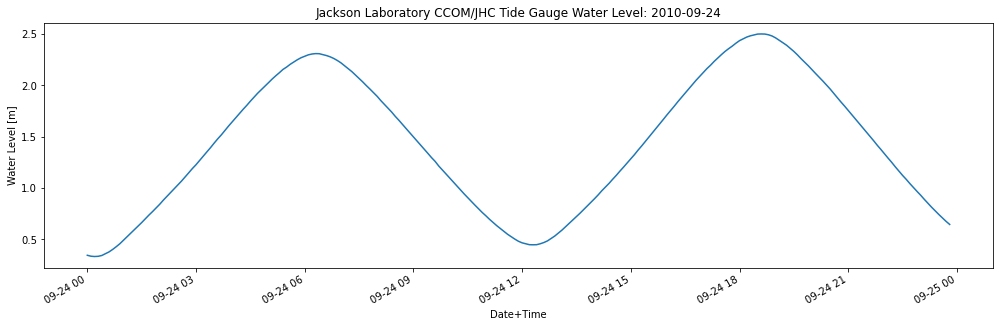

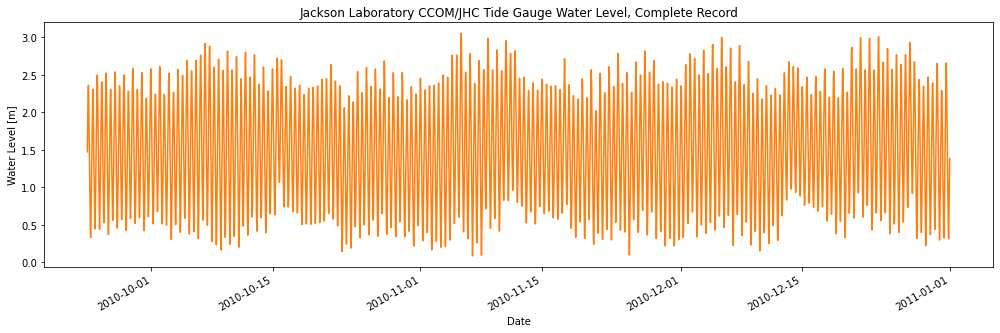

In [44]:
# 1.1.2 Plot the Jackson Laboratory Data

# Plot a single day - the first full day will be the 2nd day
day_1_start = np.where( obs_jl.index.date == obs_jl.index.date[0])[0][-1]+1
day_1_end = np.where( obs_jl.index.date == obs_jl.index.date[day_1_start])[0][-1]

# Determine the date of the first full day

day_1_date = obs_jl.index.date[day_1_start]

fig, (ax0) = plt.subplots(figsize=(17, 5), nrows=1, sharey=True, sharex=False)


# Plot the first day's worth of elevation data
ax0.plot(obs_jl.index[day_1_start:day_1_end], obs_jl.elev[day_1_start:day_1_end], label="Observations", color="C0")
plt.gcf().autofmt_xdate()
plt.title('Jackson Laboratory CCOM/JHC Tide Gauge Water Level: '+str(day_1_date))
plt.ylabel('Water Level [m]')
plt.xlabel('Date+Time')
plt.gcf().autofmt_xdate()

# Plot the entire data set
fig, (ax1) = plt.subplots(figsize=(17, 5), nrows=1, sharey=True, sharex=False)
ax1.plot(obs_jl.index, obs_jl.elev, label="Observations", color="C1")
plt.gcf().autofmt_xdate()
plt.title('Jackson Laboratory CCOM/JHC Tide Gauge Water Level, Complete Record')
plt.ylabel('Water Level [m]')
plt.xlabel('Date')
plt.gcf().autofmt_xdate()

The first subplot contains the data for the first full day of observed water level data, the date of which is contained in the variable `day_1_date`, the second is the full time series of water level observations.

___
# Fort point, New Castle, NH

<img align="left" width="40%" style="padding-right:10px;" src="Images/fort_point_1.png">
<img align="left" width="40%" style="padding-right:10px;" src="Images/fort_point_2.png">

  <br><br> This gauge was decommissioned in 2020

___
## 1.2 Read and Parse NOAA CO-OPS Water Level Data

In this section you are asked to get water level data for a period containing the epoch of the Jackson Laboratory data contained in the `obs_jl` `DataFrame`. The water level data will need to be from the gauge installed nearest to the one at the Jackson Laboratory (Adams Point), which at that time was located at Fort Point, at the US Coast Guard facility opposite the UNH pier.

## ___
### 1.2.2 Learn about the Fort Point Station

Use the tides and currents [map page](https://tidesandcurrents.noaa.gov/map/) to find the station data of the Fort Point Water Level gauge. Note that you will have to select 'Historic Data' for the **Data Type** (You are responsible for finding that option) in order for the station to show up in the map.

Answer the following questions

- q_1_2_2_0. When was the station established?
- q_1_2_2_1. What is the time meridian associated to this station?
- q_1_2_2_2. When was the station removed?
- q_1_2_2_3. What is the latitude of the station in ***decimal degrees with 4 significant figures***
- q_1_2_2_4. What is the station ID?



In [9]:
q1_2_2_0 = 'The station was established on: ...'
q_1_2_2_1 = 'The time meridian associated to this station ...'
q_1_2_2_2 = 'The station was decommissioned on: ...'
q_1_2_2_3 = 'The latitude of the station is: ... N'
q_1_2_2_4 = 'The station ID is: ... '


___
### 1.2.3 Identify Other Historic Water Level Station in the Vicinity

Use the tides and currents [map page](https://tidesandcurrents.noaa.gov/map/) to find the station ids of all the stations between (and including) Fort Point and Adams point that observed *water levels* at any point in history

Assign the answer as a list of integers to the variable `q_1_2_3_0`

In [10]:
q_1_2_3_0 = [...]


___
### 1.2.4 Dowload Water Level for the Jackson Laboratory Epoch

We will now download the data for the same epoch as for which we have data at the CCOM JHC Jackson Laboratory data

Use the tides and currents [map page](https://tidesandcurrents.noaa.gov/map/) to select the Fort Point station. 

Click on the `Station Home` button and then select Water Levels from the Tides/Water Levels drop down menu.

Specify the options for the Fort Point download to span the dates from the first record to the last record of the Jackson Laboratory data, using Metric units, the GMT Timezone, the MLLW Datum, at an 1 hr interval. 

- 1.2.4.0 Retrieve the data
- 1.2.4.1 Use the Export to CSV option
- 1.2.4.1 Rename the data downloaded data file 'FortPoint.csv'
- 1.2.4.2 Upload the 'FortPoint.csv' to the `mydata` folder of this notebook.

Sample Output:
<img align="center" width="40%" style="padding-right:10px;" src="Images/1_2_4_FP_CSV_File.png">

### 1.2.4 Take a Peek at the Data

Take a peak at the data in the 'FortPoint.csv' file in the same manner as you did for the Jackson Laboratiry data in step `1.1.0`. Update the code cell below to achieve this

In [11]:
# 1.2.5 Take a Peek at the Data

with open(os.path.join(...)) as f:
    ...

print("".join(lines[:5]))
print("...")
print("".join(lines[-5:]))


"Date","Time (GMT)","Predicted (m)","Preliminary (m)","Verified (m)"
"2010/09/23","00:00","1.148","-","1.147"
"2010/09/23","01:00","1.805","-","1.796"
"2010/09/23","02:00","2.361","-","2.346"
"2010/09/23","03:00","2.682","-","2.712"

...
"2011/01/01","19:00","-0.083","-","0.023"
"2011/01/01","20:00","-0.157","-","-0.065"
"2011/01/01","21:00","0.122","-","0.225"
"2011/01/01","22:00","0.676","-","0.794"
"2011/01/01","23:00","1.358","-","1.5"


Sample output:

    "Date","Time (GMT)","Predicted (m)","Preliminary (m)","Verified (m)"
    "2010/09/23","00:00","1.148","-","1.147"
    "2010/09/23","01:00","1.805","-","1.796"
    "2010/09/23","02:00","2.361","-","2.346"
    "2010/09/23","03:00","2.682","-","2.712"

    ...
    "2011/01/01","19:00","-0.083","-","0.023"
    "2011/01/01","20:00","-0.157","-","-0.065"
    "2011/01/01","21:00","0.122","-","0.225"
    "2011/01/01","22:00","0.676","-","0.794"
    "2011/01/01","23:00","1.358","-","1.5"


### 1.2.5 Parse the Data

We want to parse this data file into a `DataFrame` `obs_fp` in similar manner to how we read the Jackson Lab data into `obs_fp` in step `1.1.1`.

However the data structure is somewhat different. In this case use `pd.read_csv()` to read the file `FortPoint.csv` in the `DataFrame` `obs_fp`. Use the `header` to name the columns i.e., do not set the `names` argument like you did in step `1.1.1`


In [12]:
# 1.2.5 Parse the Data

obs_fp = pd.read_csv(
    os.path.join(tide_path, 'FortPoint.csv'),
    header= ...,       
    skipinitialspace=True,
    delim_whitespace=..., # In this case the delimiter is a comma
    na_values="9.990" #This is a default value for missing data
)

# Show the first five lines of data
obs_fp.head(5)

,Date,Time (GMT),Predicted (m),Preliminary (m),Verified (m)
0,2010/09/23,00:00,1.148,-,1.147
1,2010/09/23,01:00,1.805,-,1.796
2,2010/09/23,02:00,2.361,-,2.346
3,2010/09/23,03:00,2.682,-,2.712
4,2010/09/23,04:00,2.707,-,2.742


Sample output (without the nice formatting):

 	Date 	Time (GMT) 	Predicted (m) 	Preliminary (m) 	Verified (m)
    0 	2010/09/23 	00:00 	1.148 	- 	1.147
    1 	2010/09/23 	01:00 	1.805 	- 	1.796
    2 	2010/09/23 	02:00 	2.361 	- 	2.346
    3 	2010/09/23 	03:00 	2.682 	- 	2.712
    4 	2010/09/23 	04:00 	2.707 	- 	2.742

___
### 1.2.6 Replace the Index with Datetime objects and Remove Unnecessary  Columns

Use step 1.1.1.1 as an inspiration. You may run into an issue with the column labeled `Time (GMT)`. An alternative way of identifying this column is: `obs_fp['Time (GMT)']`. Also, it is easier to combine the `Date` and `Time (GMT)` columns and using the result in a call to `pandas.to_datetime()`, rather than using the sum of a `pandas.to_datetime()` and a `pandas.to_timedelta()` call.

You may combine the columns using:

    t = obs_fp.Date+' '+obs_fp['Time (GMT)']
    
and then determine the time index using

    index = pd.to_datetime(t,format='...')
    
Where you will have to replace the ellipsis by the proper format string.

Next up you will need to remove all but the `Verified (m)` columns

In [13]:
# 1.2.6 Replace the Index with Datetime objects and and Remove Unnecessary Columns

try: 
    # Create a time index using Datetimes
    t = obs_fp.Date+' '+...
    index = pd.to_datetime(t,format='...')
    obs_fp.index = index

    #  We really only need the times as date times and Verified elevations, drop the other columns
    obs_fp = obs_fp.drop([...], axis=1)

except:
    print('Already time indexed the data frame')

print(obs_fp.head(5))

                     Verified (m)
2010-09-23 00:00:00         1.147
2010-09-23 01:00:00         1.796
2010-09-23 02:00:00         2.346
2010-09-23 03:00:00         2.712
2010-09-23 04:00:00         2.742


Sample Output:

                         Verified (m)
    2010-09-23 00:00:00         1.147
    2010-09-23 01:00:00         1.796
    2010-09-23 02:00:00         2.346
    2010-09-23 03:00:00         2.712
    2010-09-23 04:00:00         2.742


___
### 1.2.7 Rename the `Verified (m) ` Column to 'elev' 

To complete the parsing rename the `Verified (m)` column of the `obs_fp` `DataFrame` to 'elev'. Check the `pandas` documentation to find the method for renaming columns

In [14]:
# 1.2.7 Rename the `Verified (m) ` Column to 'elev' 

obs_fp = obs_fp....(columns={'...:'...'} )
print(obs_fp.head(5))

                      elev
2010-09-23 00:00:00  1.147
2010-09-23 01:00:00  1.796
2010-09-23 02:00:00  2.346
2010-09-23 03:00:00  2.712
2010-09-23 04:00:00  2.742


Sample Output:

                          elev
    2010-09-23 00:00:00  1.147
    2010-09-23 01:00:00  1.796
    2010-09-23 02:00:00  2.346
    2010-09-23 03:00:00  2.712
    2010-09-23 04:00:00  2.742



# 1.2.8 Plot the Fort Point Data

The Fort Point data is now parsed, it is contained in the `obs_fp` `DataFrame`. This step will visualize the data for the same date as in step 1.1.2. Note that the date is already identified and contained in the variable `obs_fp`. This simplifies the determination of the indexes `day_1_start` and `day_1_end`.

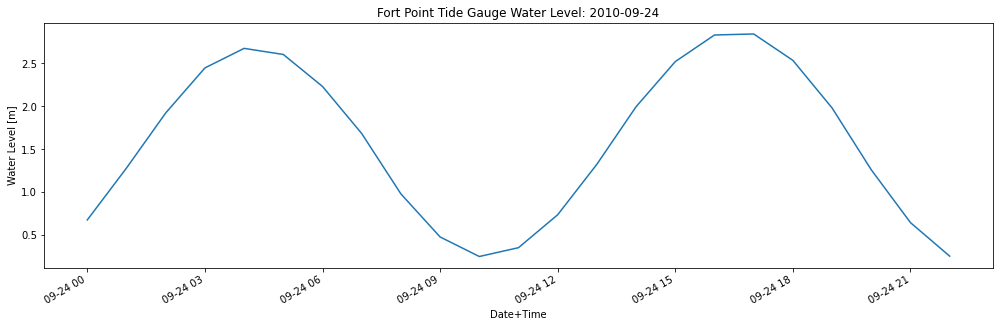

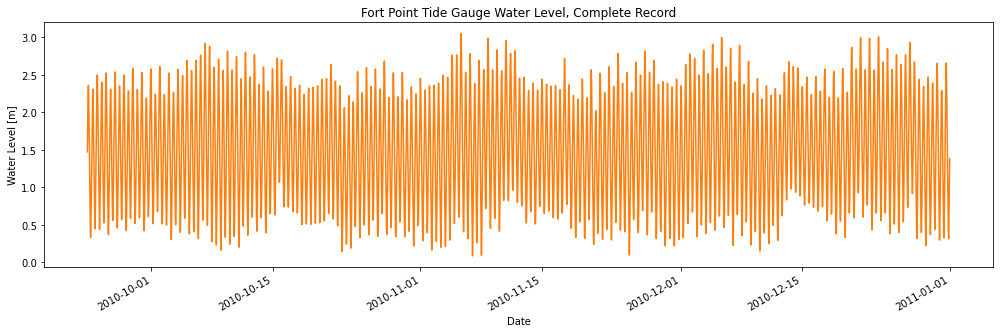

In [15]:
# 1.2.8 Plot the Jackson Laboratory Data

# Plot a single day - the first full day will be the 2nd day
day_1_start = np.where( obs_fp.index.date == day_1_date)[0][0]
day_1_end = np.where( obs_fp.index.date == day_1_date)[0][-1]

fig, (ax0) = plt.subplots(figsize=(17, 5), nrows=1, sharey=True, sharex=False)

# Plot the first day's worth of elevation data
ax0.plot(obs_fp.index[day_1_start:day_1_end], obs_fp.elev[...], label="Observations", color="C0")
plt.gcf().autofmt_xdate()
plt.title('Fort Point Tide Gauge Water Level: '+str(day_1_date))
plt.ylabel('Water Level [m]')
plt.xlabel('Date+Time')
plt.gcf().autofmt_xdate()

# Plot the entire data set
fig, (ax1) = plt.subplots(figsize=(17, 5), nrows=1, sharey=True, sharex=False)
ax1.plot(..., ..., label="Observations", color="C1")
plt.gcf().autofmt_xdate()
plt.title('Fort Point Tide Gauge Water Level, Complete Record')
plt.ylabel('Water Level [m]')
plt.xlabel('Date')
plt.gcf().autofmt_xdate()

Sample Output: 
<img align="center" width="40%" style="padding-right:10px;" src="Images/1_2_8_FP_Water_Levels.png"><img align="center" width="40%" style="padding-right:10px;" src="Images/1_2_8_FP_Water_Levels_Full.png">

# 2 Analysis

We will initially look at the data in a very simple fashion by plotting the first full day of both time series and performing some simple analysis. Though that will allow you to get a basic feeling for the data, it will not allow for the determination of tidal constituents. Therefore we will complete an analysis using the method of the least squares as implemented in the `UTide` python module. However, this module is to be seen as an introduction to working with tides and not an-depth treatise. We will therefore not address the various `Utide` options in great detail.

___
## 2.1 Basic Analysis

Start by plotting the data of a full day contained in both time series. We already have the variable `day_1_date` containing such a date, so we will use this. 

### 2.1.1 Sub-Setting Data at Common Epochs

The problem is that the data for the Fort Point station are at 1 hour interval, whereas the Jackson Lab data are at 6 minute intervals. We could overcome this by interpolating the data, but since there are data at common points in time this is unnecessarry. We may make convenient use of the indexes of the `DataFrames` to simply subset the data sets by using the following:

    day_1_fp_dates = obs_fp.index[obs_fp.index.date == day_1_date]
    day_1_fp_indexes = np.where(obs_fp.index.isin(day_1_fp_dates))[0]
    day_1_jl_indexes = np.where(obs_jl.index.isin(day_1_fp_dates))[0]

Convince yourself that you understand what the above code snippet does

In [16]:
## 2.1.1 Sub-Setting Data at Common Epochs

day_1_fp_dates = obs_fp.index[obs_fp.index.date == day_1_date]
day_1_fp_indexes = np.where(obs_fp.index.isin(day_1_fp_dates))[0]
day_1_jl_indexes = np.where(obs_jl.index.isin(day_1_fp_dates))[0]

print(obs_fp.index[day_1_fp_indexes][0:5])
print(obs_jl.index[day_1_jl_indexes][0:5])


DatetimeIndex(['2010-09-24 00:00:00', '2010-09-24 01:00:00',
               '2010-09-24 02:00:00', '2010-09-24 03:00:00',
               '2010-09-24 04:00:00'],
              dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2010-09-24 00:00:00', '2010-09-24 01:00:00',
               '2010-09-24 02:00:00', '2010-09-24 03:00:00',
               '2010-09-24 04:00:00'],
              dtype='datetime64[ns]', freq=None)


___
### 2.1.2 Plotting Data at Common Epochs

We may now plot the data for the first full day of the Fort Point data at the common epochs

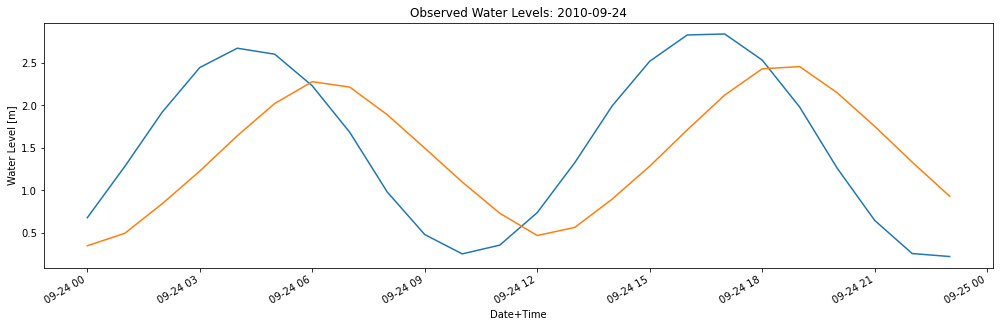

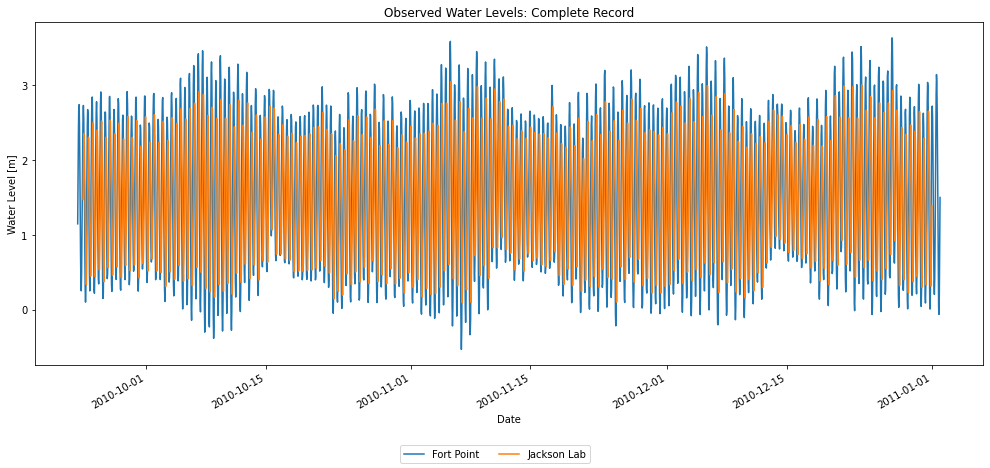

In [17]:
# 2.1.2 Plotting Data at Common Epochs

fig, (ax0) = plt.subplots(figsize=(17, 5), nrows=1, sharey=True, sharex=False)

# Plot the first day's worth of elevation data
ax0.plot(obs_fp.index[day_1_fp_indexes], obs_fp.elev[...], label="Fort Point", color="C0")
ax0.plot(obs_jl.index[...], ..., label="Jackson Lab", color="C1")
plt.gcf().autofmt_xdate()
plt.title('Observed Water Levels: '+str(day_1_date))
plt.ylabel('Water Level [m]')
plt.xlabel('Date+Time')
plt.gcf().autofmt_xdate()

# Plot the entire data sets

fig, (ax1) = plt.subplots(figsize=(17, 7), nrows=1, sharey=True, sharex=False)
ax1.plot(obs_fp.index, obs_fp.elev, label="Fort Point", color="C0")
ax1.plot(obs_jl...., ..., label="Jackson Lab", color="C1")
plt.gcf().autofmt_xdate()
plt.title('Observed Water Levels: Complete Record')
plt.ylabel('Water Level [m]')
plt.xlabel('Date')
fig.legend(ncol=3, loc="lower center")
plt.gcf().autofmt_xdate()


Sample Output:
<img align="center" width="40%" style="padding-right:10px;" src="Images/2_1_2FP_JL_Data_Common_Epoch.png">
<img align="center" width="40%" style="padding-right:10px;" src="Images/2_1_2FP_JL_Data_Common_Epoch_Full.png">

From the lower plot it is obvious that the water levels at both stations act similarly, though the range at Jackson Lab is attenuated. It is also clear that there is a significant delay with respect to the Fort Point station that is on the order of 2 hours. Comparing the data is complicated by the fact that they are not on the same datum (Fort Point is relative to MLLW, the Jackson Lab data is on a datum relative to the gauge).

### 2.1.3 Water Levels as Anomalies

To address the fact that data are not on a common datum has the potential to complicate the analysis of the data. It is therefore common to interpret the water levels as anomalies i.e., to determine a mean water level (MSL) for the time series and offsetting all the observations by this mean.

You may add a column to the `DataFrame` in a similar way to how this is done with a `dict` i.e., to add a column `anomaly` we may use:

    obs_jl['anomaly'] = ...
    
In the code cell below add the column to both `obs_jl` and `obs_fp`. Make sure that the columns contain the water levels as anomalies, use the `mean()` method for this purpose

In [18]:
obs_jl['anomaly'] = obs_jl["elev"] - obs_jl["elev"].mean()
obs_fp['anomaly'] = ...

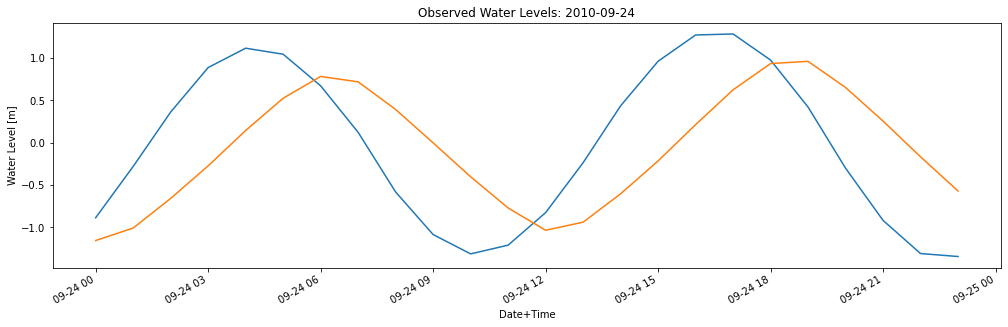

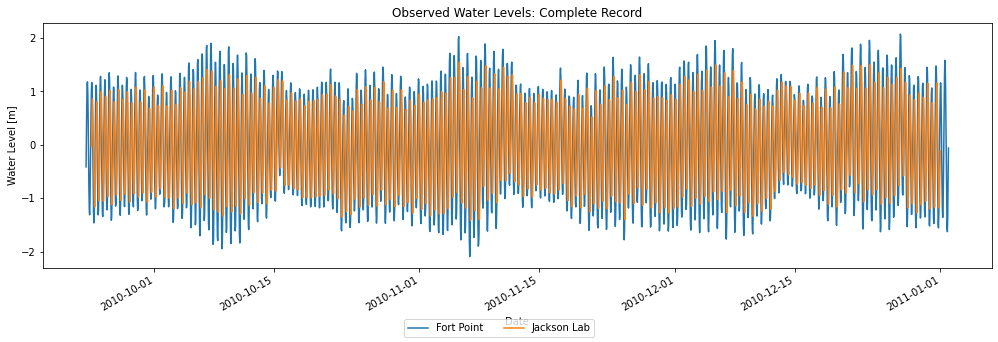

In [19]:
# 2.1.3 Plot the first full data

fig, (ax0) = plt.subplots(figsize=(17, 5), nrows=1, sharey=True, sharex=False)

# Plot the first day's worth of elevation data
ax0.plot(obs_fp.index[day_1_fp_indexes], obs_fp.anomaly[day_1_fp_indexes], label="Fort Point", color="C0")
ax0.plot(obs_jl.index[...], ..., label="Jackson Lab", color="C1")
plt.gcf().autofmt_xdate()
plt.title('Observed Water Levels: '+str(day_1_date))
plt.ylabel('Water Level [m]')
plt.xlabel('Date+Time')
plt.gcf().autofmt_xdate()

# Plot the entire data sets

fig, (ax1) = plt.subplots(figsize=(17, 5), nrows=1, sharey=True, sharex=False)
ax1.plot(obs_fp.index, obs_fp.anomaly, label="Fort Point", color="C0")
ax1.plot(obs_jl.index, obs_jl.anomaly, label="Jackson Lab", color="C1")
plt.gcf().autofmt_xdate()
plt.title('Observed Water Levels: Complete Record')
plt.ylabel('Water Level [m]')
plt.xlabel('Date')
fig.legend(ncol=3, loc="lower center")
plt.gcf().autofmt_xdate()


Sample Output: 
<img align="center" width="40%" style="padding-right:10px;" src="Images/2_1_3_FP_JL_Data_Anomaly_Common_Epoch.png">
<img align="center" width="40%" style="padding-right:10px;" src="Images/2_1_3_FP_JL_Data_Anomaly_Common_Epoch_Full.png">

### 2.1.4 Analysis Using Fast Fourier Transforms

We will take the analysis a small step further by looking at the spectrum of the data. This allows us to get an estimate of the amplitude associated to the various harmonic constituents. In the code cell below you will see how the spectrum of the water level for the Fort Point tides is derived.

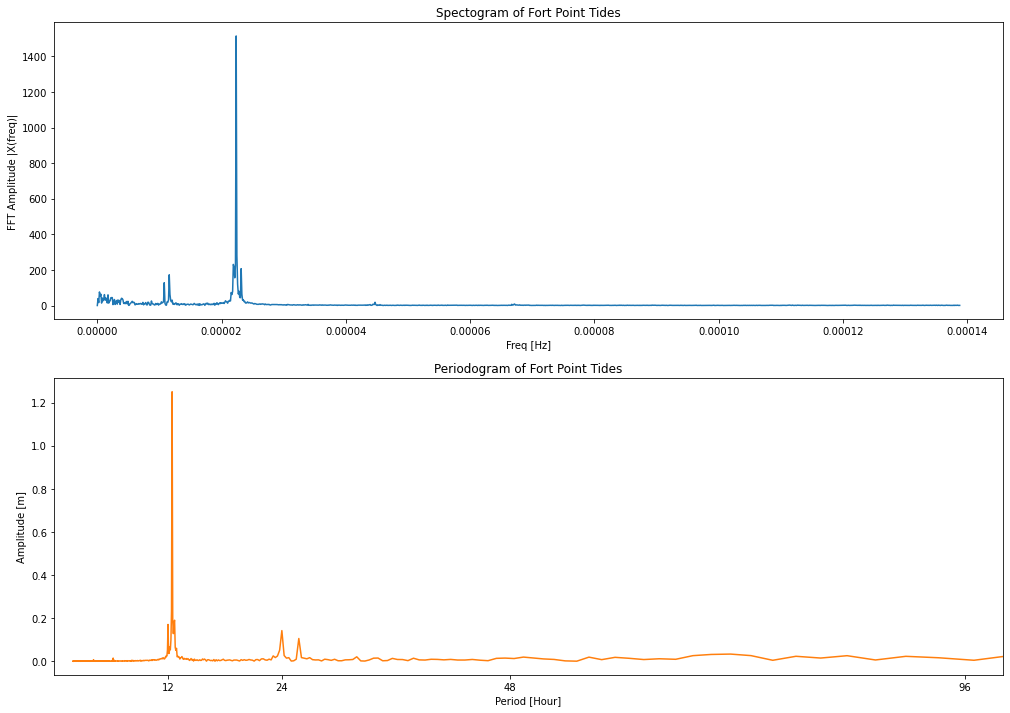

In [20]:
# Create a spectrum using a FFT

df = obs_fp

X = fft(df['anomaly'])
N = len(df)
n = np.arange(N)
dt = (df.index[1]-df.index[0]).total_seconds()
sr = 1 / dt
T = N/sr
freq = n/T 

# Get the one-sided specturm

n_oneside = N//2

# get the one sided frequency range
f_oneside = freq[:n_oneside]

# Get the one sided period range
t_h = 1/f_oneside[1:] / dt

# Plot the spectrum
fig, (ax0, ax1) = plt.subplots(figsize=(17, 12), nrows=2, sharey=False, sharex=False)
ax0.plot(f_oneside, np.abs(X[:n_oneside]), 'C0')
ax0.set_title('Spectogram of Fort Point Tides')
ax0.set(xlabel='Freq [Hz]')
ax0.set(ylabel='FFT Amplitude |X(freq)|')

# Plot the periodogram
ax1.plot(t_h, np.abs(X[1:n_oneside])/(n_oneside-1),'C1')
ax1.set_title('Periodogram of Fort Point Tides')
ax1.set(ylabel='Amplitude [m]')
ax1.set(xlabel='Period [Hour]')
ax1.set_xlim(0, 100)
ax1.set_xticks([12, 24 ,48, 96])

plt.show()

In [21]:
# Illustration of FFT problems

# Find the index associated to the maximum amplitude in the spectrum
max_f = np.argmax(np.abs(X[1:n_oneside]))

# Find the associated period
t_max = t_h[max_f]

print('The maximum is associated to period: %.3f hours'%t_max)

The maximum is associated to period: 12.431 hours


In the code cell above you see that the maximum response in the tidal spectrum is associated to a period line of 12.431 hours. This period matches none of the tidal constituents, but is close to that of several of the semi diurnal tides such as $M2$, $N2$, and $S2$. This is due to the fact that the Fast Fourier Transform has a frequency and period resolution that is determined by the number of samples; to ensure that all the constituents are covered exactly therefore requires significantly high sampling rates and/or long epochs of records. 

From this limited resolution it is easy to understand that significant correlation in the analysis of amplitudes and phases of nearby frequencies may occur. Though steps may be taken to get better results with Fourier Transforms using the approaches described [here](Documents/Tidal_Analysis_and_Predictions.pdf) most organizations outside NOAA CO-OPS use the **least squares method (LSM or MLS)** and/or a wavelet transform. It should be noted that the performance of either these approaches is still dependent on sampling rate and the length of the record - if the record is sufficiently long there will be no statistically significant difference between the records.

___
## 2.2 Analysis Using the Method of Least Squares

For MLS we can fit data to specific pre-determined frequencies associated to the tidal constituents, thereby reducing the correlation between frequency adjacent tidal constituents due to insufficient resolution; this is the approach taken in `t_tide` and `u_tide`. Also, the method of the least squares inherently allows for the explicit estimation of the correlation between tidal constituent estimates, making it a suitable tool for tidal analysis.

Due to the tidal frequencies being fixed inputs MLS analysis does not rely on a evenly spaced sampling interval. Thus reconstruction of tides from observations of opportunity is possible. For example data collected from a ferry moving along a transect may be used for any location along the transect (assuming that there are enough observations for that location).

For those knowledgeable of MLS: we will make use of ordinary least squares analysis instead of iteratively reweighed least squares (IRLS). IRLS has some computational advantages, but requires a thorough understanding of the method of the least squares. 

We will also make use of automatically selected constituents, chosen on the likelihood of them being independent of each other. We will use linear confidence intervals as determined by the least squares method; an alternative would be to use the `'MC'` option which uses a Monte-Carlo simulation to predict different outcomes and determine the confidence intervals associated to them. This Notebook is written with the expectation that you do not know  how Monte-Carlo simulation works, and a thorough explanation is outside the scope of this assignment; the `MC` option would lead to a better estimate the covariances and thus lead to marginally better results. 


___
## 2.2.1 `Utide` Analysis of Jackson Laboratory Water Levels

In [22]:
coef_jl = utide.solve(
    obs_jl.index,
    obs_jl["anomaly"],
    lat=43.07,
    method="ols",
    conf_int="linear",
    verbose=True,
)

solve: matrix prep ... solution ... done.


The code cell above calls the `Utide` solve method which is used to estimate the tidal coefficients. This is achieved by using MLS to fit all possible constituents. A subset of constituents for which good results may be obtained is then selected automatically. Note that it is to be expected that there is an up- or downward trend in the data due to the relatively short duration, to not bias the results of teh analysis the data are de-trended by default. Also, the phase angles are calculated with respect to the Greenwhich Meridian passage by  default, meaning that the estimated phases are valid for a UTC time base.

The code cell below takes the results from the `Utide` analysis and shows them in a format similar (not the same!) to what is shown for the **Station Home** page for the NOAA CO-OPS gauges.

In [23]:
print(f"{'Darwin':>9}"f"{'T [h]':>9}", f"{'Amp':>6}", f"{'95%ci':>7}",
      f"{'phase':>8}", f"{'95%ci':>9}", f"{'Energy %':>9}", f"{'SNR':>9}")
for i in range(len(coef_jl['name'])):
    print('% 9s%9.3f%7.2f%8.3f%9.1f%10.1f%10.3f%10.2f' % (coef_jl.name[i],
                                                          1/coef_jl.aux.frq[i],
                                                          coef_jl.A[i],
                                                          coef_jl.A_ci[i],
                                                          coef_jl.g[i],
                                                          coef_jl.g_ci[i],
                                                          coef_jl.PE[i], 
                                                          coef_jl.SNR[i]))

   Darwin    T [h]    Amp   95%ci    phase     95%ci  Energy %       SNR
       M2   12.421   0.92   0.006    165.9       0.4    91.536  86760.57
       N2   12.658   0.17   0.006    131.3       2.0     3.199   3032.80
       K1   23.934   0.12   0.005    236.3       2.6     1.519   1825.44
       S2   12.000   0.10   0.006    198.8       3.4     1.162   1101.60
       L2   12.192   0.10   0.006    196.9       3.5     1.059   1003.95
       O1   25.819   0.09   0.005    224.0       3.7     0.787    945.98
       MM  661.309   0.04   0.030     92.6      43.8     0.170      6.57
      MU2   12.872   0.04   0.006    268.6       8.9     0.167    158.39
       M6    4.140   0.04   0.002    136.1       3.7     0.154    909.82
      MSF  354.367   0.03   0.030     84.9      69.1     0.068      2.65
     2MN6    4.166   0.02   0.002     96.3       7.0     0.044    259.83
      MO3    8.386   0.01   0.001    271.0       4.8     0.018    537.94
     EPS2   13.127   0.01   0.006    222.0      27.

Use the table above to answer the following questions:
- q_2_2_1_1: Explain what determines the level of significance for the tidal constituents.
- q_2_2_1_2: Explain whether errors in the estimation of anything but the 6 most significant coefficients listed above makes much of a difference for tide prediction at this particular location if the record were decades long instead.
- q_2_2_1_3: From the data seen above can you make a general statement about how many coefficients are minimally needed to reconstruct 99.5% of this tidal height signal?
- q_2_2_1_4: Select the M2 constituent to estimate the time difference at which you would expect the same tidal phase at both locations. Explain how you calculated your estimate
- q_2_2_1_5: In the table the `95%ci` and `SNR` are both indicators of data quality, which do you think is better indicator of potential bias?
- q_2_2_1_6: When predicting tide, which combination for a particular constituent's values do you think affects the result the worst:
    - a. low `Amp` with low `SNR`
    - b. low `Amp` with high `SNR`
    - c. high `Amp` with low `SNR`
    - d. high `Amp` with high `SNR`


In [24]:
# 2.2.1
q_2_2_1_1 = 'The level of significance for the tidal constituents is determined by ...'
q_2_2_1_2 = 'Using more than the 6 most significant listed constituents above  would make a ...'
q_2_2_1_3 = 'From the data seen above you would need ... constituents to reconstruct 99.5% of the signal'
q_2_2_1_4 = ' I estimate the time difference for the same tidal phase to be ... hours. I calculated this by'
q_2_2_1_5 = 'Between the `95%ci` and `SNR` I think ... is the better indicator of potential bias'
q_2_2_1_5 = 'a, b, c, or d'


___
## 2.2.2 `Utide` Analysis of Fort Point Water Levels

In [45]:
# 2.2.2

coef_fp = utide.solve(
    obs_fp.index,
    ...,
    ...,
    ...,
    ...,
    verbose=True,
)

TypeError: solve() takes from 2 to 4 positional arguments but 5 were given

Update the code cell above so that the tidal constituents for the Fort Point station are estimated

In [46]:
print(f"{'Darwin':>9}"f"{'T [h]':>9}", f"{'Amp':>6}", f"{'95%ci':>7}",
      f"{'phase':>8}", f"{'95%ci':>9}", f"{'Energy %':>9}", f"{'SNR':>9}")
for i in range(len(coef_fp['name'])):
    print('% 9s%9.3f%7.2f%8.3f%9.1f%10.1f%10.3f%10.2f' % (coef_fp.name[i],
                                                          1/coef_fp.aux.frq[i],
                                                          coef_fp.A[i],
                                                          coef_fp.A_ci[i],
                                                          coef_fp.g[i],
                                                          coef_fp.g_ci[i],
                                                          coef_fp.PE[i], 
                                                          coef_fp.SNR[i]))

   Darwin    T [h]    Amp   95%ci    phase     95%ci  Energy %       SNR
       M2   12.421   1.30   0.009    105.7       0.4    91.327  89207.86
       N2   12.658   0.29   0.009     67.6       1.7     4.414   4314.54
       S2   12.000   0.19   0.009    128.4       2.6     1.879   1836.16
       K1   23.934   0.15   0.006    192.3       2.4     1.236   2129.45
       O1   25.819   0.11   0.006    181.7       3.5     0.607   1045.77
       L2   12.192   0.08   0.009    159.8       6.0     0.355    346.94
       MM  661.309   0.03   0.030    108.6      56.1     0.050      4.02
      MSF  354.367   0.03   0.030    117.0      59.4     0.044      3.59
      MU2   12.872   0.02   0.009    157.2      23.1     0.024     23.68
       M4    6.210   0.02   0.001    325.6       3.6     0.014    985.09
       J1   23.098   0.02   0.006    222.7      23.5     0.013     22.82
       Q1   26.868   0.01   0.006    137.8      26.6     0.010     17.86
       M6    4.140   0.01   0.001    147.6       6.

Sample Output:

    Darwin    T [h]    Amp   95%ci    phase     95%ci  Energy %       SNR
           M2   12.421   1.30   0.009    105.7       0.4    91.327  89207.86
           N2   12.658   0.29   0.009     67.6       1.7     4.414   4314.54
           S2   12.000   0.19   0.009    128.4       2.6     1.879   1836.16
           K1   23.934   0.15   0.006    192.3       2.4     1.236   2129.45
           O1   25.819   0.11   0.006    181.7       3.5     0.607   1045.77
           L2   12.192   0.08   0.009    159.8       6.0     0.355    346.94
           MM  661.309   0.03   0.030    108.6      56.1     0.050      4.02
          MSF  354.367   0.03   0.030    117.0      59.4     0.044      3.59
          MU2   12.872   0.02   0.009    157.2      23.1     0.024     23.68
           M4    6.210   0.02   0.001    325.6       3.6     0.014    985.09
           J1   23.098   0.02   0.006    222.7      23.5     0.013     22.82
           Q1   26.868   0.01   0.006    137.8      26.6     0.010     17.86
           M6    4.140   0.01   0.001    147.6       6.0     0.005    354.14
          NO1   24.833   0.01   0.006    220.7      39.6     0.005      8.04
         UPS1   21.578   0.01   0.006    100.7      48.3     0.003      5.40
          MN4    6.269   0.01   0.001    295.5       9.7     0.002    134.34
         2MN6    4.166   0.01   0.001    104.4      10.1     0.002    122.47
          2Q1   28.006   0.01   0.006      0.9      68.7     0.002      2.67
          MO3    8.386   0.00   0.001    227.6       8.9     0.001    159.89
          MK3    8.177   0.00   0.001    231.7      10.4     0.001    117.09
          MS4    6.103   0.00   0.001      4.7      14.1     0.001     63.92
          OO1   22.306   0.00   0.006    300.9      90.4     0.001      1.54
         EPS2   13.127   0.00   0.009     89.9     142.7     0.001      0.62
         2MS6    4.092   0.00   0.001    167.6      17.4     0.001     41.72
           M3    8.280   0.00   0.001    119.2      16.7     0.000     45.34
         ALP1   29.073   0.00   0.006     89.0     154.7     0.000      0.53
         ETA2   11.755   0.00   0.009    106.9     211.1     0.000      0.28
          SN4    6.160   0.00   0.001     34.2      25.0     0.000     20.25
         2MK5    4.931   0.00   0.001    108.2      16.6     0.000     45.52
           M8    3.105   0.00   0.001    295.9      17.3     0.000     41.92
          SK3    7.993   0.00   0.001    332.4      28.1     0.000     15.96
         2SK5    4.797   0.00   0.001    253.4      24.2     0.000     21.57
         3MK7    3.530   0.00   0.001    301.8      39.9     0.000      7.93
           S4    6.000   0.00   0.001      5.8      87.3     0.000      1.66
         2SM6    4.046   0.00   0.001    229.1     120.1     0.000      0.87

Go back to the station data for the Fort Point tide gauge at the [CO-OPS map](https://tidesandcurrents.noaa.gov/map/) and compare the published values for the Harmonic Constituents with the table above (Make sure to use meters and UTC time for the CO-OPS estimated harmonic coefficients!). You will see that the estimates for the Amplitude and Phase are quite similar for the most significant tides. However, given that there are no significant differences in the numerical approaches how we estimated the coefficients here and how CO-OPS estimates the coefficients they are still significant. 

- q_2_2_2_1: Explain what the most important reason is that the estimates are slightly different knowing that:
    - 1. We can get our estimates significantly closer to the CO-OPS estimates by downloading more data
    - 2. One hour intervals are small enough to easily meet the Nyquist sampling intervals for all constituents.
    - 3. Changing the `method` and `conf_int` in the call to `utide.solve()` will result only in marginal differences.
 

In [27]:
# 2.2.2
q_2_2_2_1 = 'The most important reason for the differences in the estimated constituents is ...'

aq_2_2_2_1 = 'The most important reason for the differences in the estimated constituents is the length of the observation record'

___
## 2.3 Tidal Reconstruction and Prediction

**Tidal reconstruction** is done through the summation of all available harmonic constituents. Tidal reconstrcution is the generation of a tidal signal matching the observation period. Tidal reconstruction thus allows for the removal of the tidal influence on the water level leading to a residual water level signal that is due to non-tidal influences. This residual signal may then be further analyzed. Tidal reconstruction is a powerful tool for physical oceanography and many other applications.

**Tidal prediction** uses the same harmonic constituents, but to predict water levels before (hind-casting) are after (fore-casting) the observation period. Tidal prediction is an invaluable tool for navigation, as well as many other activities in the near coastal zones. 

The `utide.reconstruct()` function is used for both reconstruction and prediction; the only difference being the epoch for which the function is used.

Though the summation may be thought of the summation of a series of cosines, as shown on the [CO-OPS web page describing harmonic constituents](https://tidesandcurrents.noaa.gov/about_harmonic_constituents.html) it is implemented in the form of weighed least squares solution in `Utide`, where the weights are determined by the uncertainty levels associated to the tidal harmonic coefficient estimates.

In [28]:
# Create tidal predictions for the same epochs for which observation data where gathered

tide_jl = utide.reconstruct(obs_jl.index, coef_jl, verbose=True)
res_jl =  obs_jl.anomaly - tide_jl.h

prep/calcs ... done.


The code cell above then results in the reconstruction of the tides at the Jackson Lab.

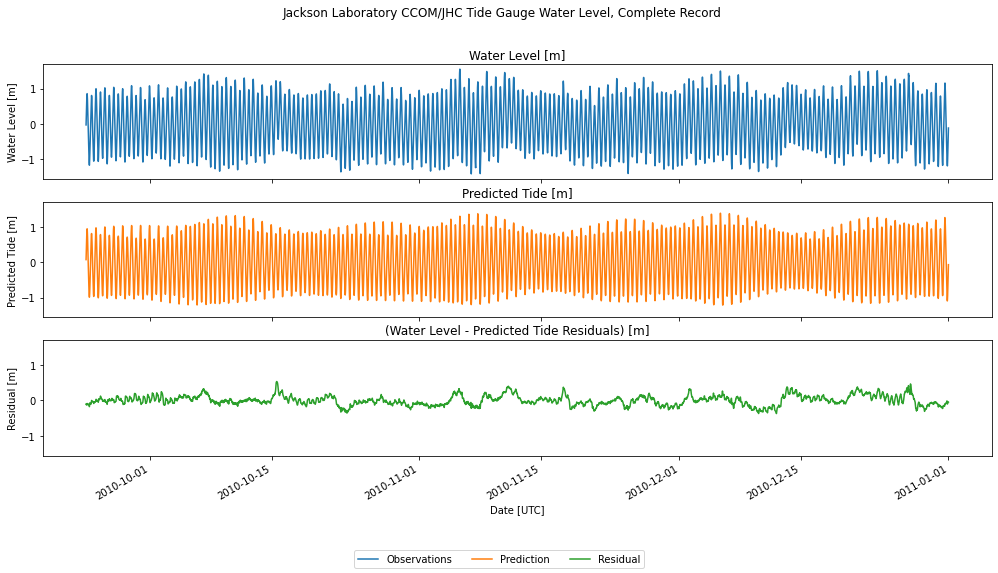

In [29]:
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 8), nrows=3, sharey=True, sharex=True)

ax0.plot(obs_jl.index, obs_jl.anomaly, label="Observations", color="C0")
ax0.set_title('Water Level [m]')
ax0.set(ylabel='Water Level [m]')
ax1.plot(obs_jl.index, tide_jl.h, label="Prediction", color="C1")
ax1.set_title('Predicted Tide [m]')
ax1.set(ylabel='Predicted Tide [m]')
ax2.plot(obs_jl.index, res_jl, label="Residual", color="C2")
ax2.set_title('(Water Level - Predicted Tide Residuals) [m]')
ax2.set(ylabel='Residual [m]')
ax2.set(xlabel='Date [UTC]')
plt.gcf().autofmt_xdate()
plt.suptitle('Jackson Laboratory CCOM/JHC Tide Gauge Water Level, Complete Record')
# plt.ylabel('Water Level [m]')
plt.gcf().autofmt_xdate()
fig.legend(ncol=3, loc="lower center");

The code cell above results in the visualization of the observed water level, the reconstructed tidal signal contained therein, and finally, the residual signal due to non-tidal processes

In [30]:
# Reconstruct the 5 most significant constituents at Fort Point

pred_0_jl = utide.reconstruct(obs_jl.index, coef_jl,constit=coef_jl.name[0:1])
pred_1_jl = utide.reconstruct(obs_jl.index, coef_jl,constit=coef_jl.name[1:2])
pred_2_jl = utide.reconstruct(obs_jl.index, coef_jl,constit=coef_jl.name[2:3])
pred_3_jl = utide.reconstruct(obs_jl.index, coef_jl,constit=coef_jl.name[3:4])
pred_4_jl = utide.reconstruct(obs_jl.index, coef_jl,constit=coef_jl.name[4:5])


prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.


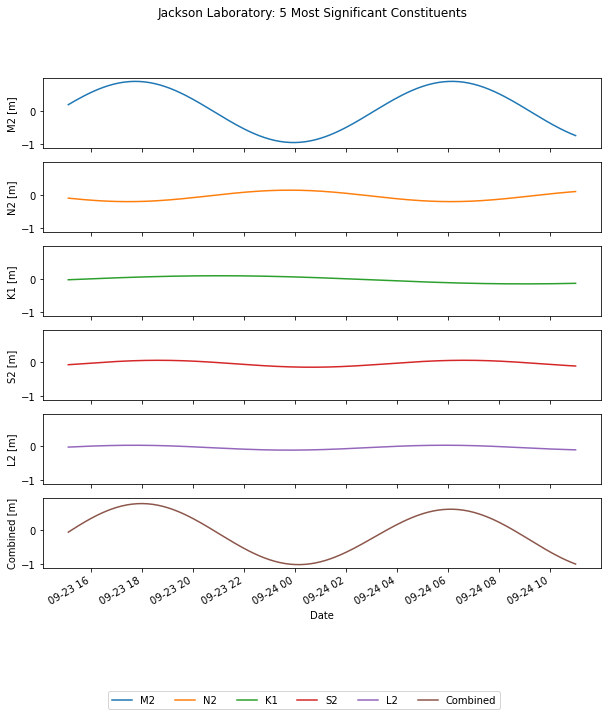

In [31]:
# Plot the 5 most significant tidal constituents and their combined sum

pred_5c_jl = pred_0_jl.h+pred_1_jl.h+pred_2_jl.h+pred_3_jl.h+pred_4_jl.h

fig, (ax0, ax1, ax2,ax3,ax4, ax5) = plt.subplots(nrows=6, sharey=True, sharex=True,figsize=(10, 10))
ax0.plot(obs_jl.index[0:200],pred_0_jl.h[0:200], label=coef_jl.name[0:1][0], color="C0")
ax0.set(ylabel=coef_jl.name[0:1][0]+' [m]')
ax1.plot(obs_jl.index[0:200],pred_1_jl.h[0:200], label=coef_jl.name[1:2][0], color="C1")
ax1.set(ylabel=coef_jl.name[1:2][0]+' [m]')
ax2.plot(obs_jl.index[0:200],pred_2_jl.h[0:200], label=coef_jl.name[2:3][0], color="C2")
ax2.set(ylabel=coef_jl.name[2:3][0]+' [m]')
ax3.plot(obs_jl.index[0:200],pred_3_jl.h[0:200], label=coef_jl.name[3:4][0], color="C3")
ax3.set(ylabel=coef_jl.name[3:4][0]+' [m]')
ax4.plot(obs_jl.index[0:200],pred_4_jl.h[0:200], label=coef_jl.name[4:5][0], color="C4")
ax4.set(ylabel=coef_jl.name[4:5][0]+' [m]')
ax5.plot(obs_jl.index[0:200],pred_5c_jl[0:200], label='Combined', color="C5")
ax5.set(ylabel='Combined [m]')

fig.legend(ncol=6, loc="lower center")
plt.suptitle('Jackson Laboratory: 5 Most Significant Constituents')
plt.xlabel('Date')
plt.gcf().autofmt_xdate()
plt.show()

Sample Output: 
<img align="center" width="40%" style="padding-right:10px;" src="Images/2_3_JL_reconstruction_5.png">


The two code cells above illustrate the tidal reconstruction for individual harmonic signals, and their summation to create a complex tidal signal.

### 2.3.1 Tidal Reconstruction at Fort Point

Complete the code below to reconstruct the tides at Fort Point

In [32]:
# Create tidal predictions for the same epochs for which observation data where gathered

tide_fp = utide.reconstruct(...)
res_fp =  ...

prep/calcs ... done.


Complete the code cell below to visualize the observed data, derived tide model, and residuals 

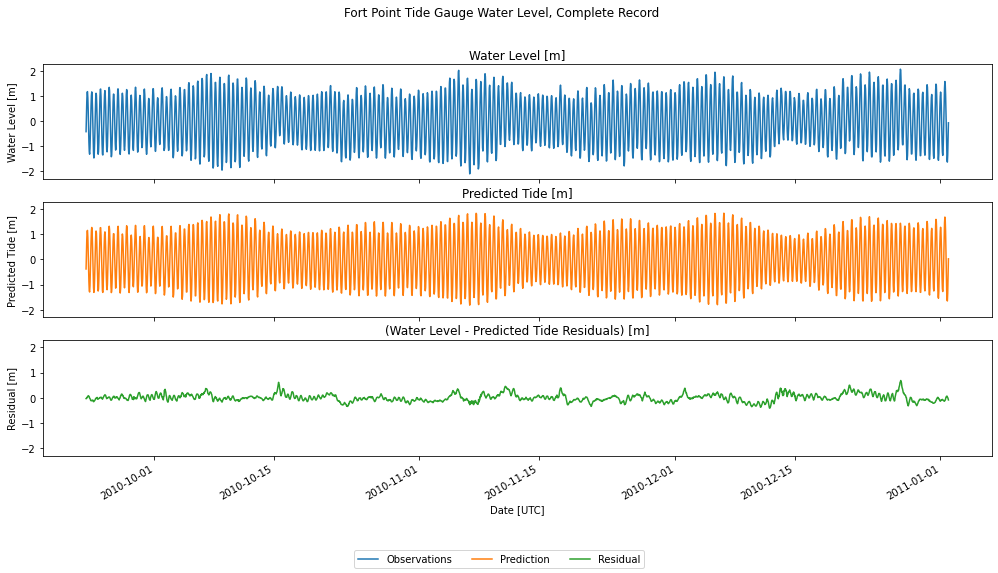

In [33]:
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 8), nrows=3, sharey=True, sharex=True)

ax0.plot(obs_fp.index, obs_fp.anomaly, label="Observations", color="C0")
ax0.set_title('Water Level [m]')
ax0.set(ylabel='Water Level [m]')
ax1.plot(obs_fp.index, tide_fp.h, label="Prediction", color="C1")
ax1.set_title('Predicted Tide [m]')
ax1.set(ylabel='Predicted Tide [m]')
ax2.plot(obs_fp.index, res_fp, label="Residual", color="C2")
ax2.set_title('(Water Level - Predicted Tide Residuals) [m]')
ax2.set(ylabel='Residual [m]')
ax2.set(xlabel='Date [UTC]')
plt.gcf().autofmt_xdate()
plt.suptitle('Fort Point Tide Gauge Water Level, Complete Record')
# plt.ylabel('Water Level [m]')
plt.gcf().autofmt_xdate()
fig.legend(ncol=3, loc="lower center");

# 3 Residual Water Level Differences

The residual water levels are a topic of interest for many. They indicate the water level variations that are due to non-tidal influences. Due to the fact that they are obtained by removing a modeled tide signal from observed water levels there are inherent errors associated to the residuals.

Here we will have a quick look at some of the residual properties

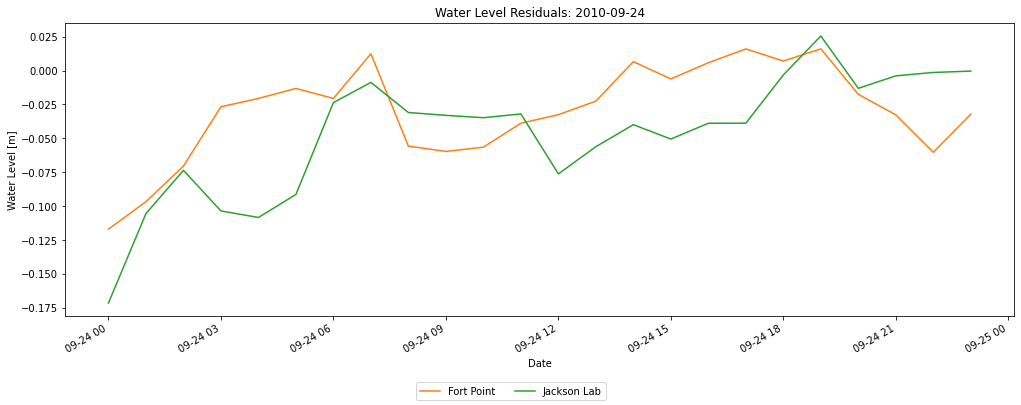

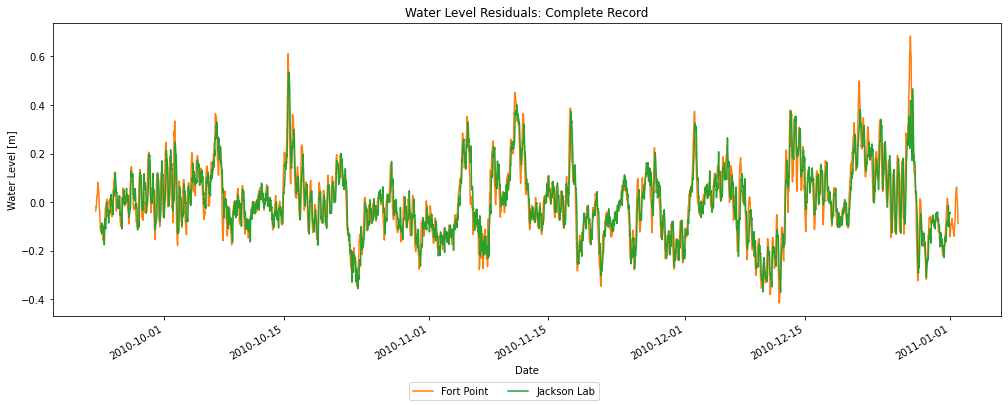

In [34]:
fig, (ax0) = plt.subplots(figsize=(17, 6), nrows=1, sharey=True, sharex=False)
ax0.plot(obs_fp.index[day_1_fp_indexes], res_fp[day_1_fp_indexes], label="Fort Point", color="C1")
ax0.plot(obs_jl.index[day_1_jl_indexes], res_jl[day_1_jl_indexes], label="Jackson Lab", color="C2")

plt.title('Water Level Residuals: '+str(day_1_date))
plt.ylabel('Water Level [m]')
plt.xlabel('Date')
fig.legend(ncol=3, loc="lower center")
plt.gcf().autofmt_xdate()

fig, (ax1) = plt.subplots(figsize=(17, 6), nrows=1, sharey=True, sharex=False)
ax1.plot(obs_fp.index, res_fp, label="Fort Point", color="C1")
ax1.plot(obs_jl.index, res_jl, label="Jackson Lab", color="C2")
# ax0.set_title('(Water Level - Predicted Tide Residuals) [m]')



plt.title('Water Level Residuals: Complete Record')
plt.ylabel('Water Level [m]')
plt.xlabel('Date')
fig.legend(ncol=3, loc="lower center")
plt.gcf().autofmt_xdate()

From the residual signals at either station shown above it is clear that they are not primarily due to instrument noise.

- q3_1: Explain why the plots above show that the residuals are due primarily to factors other than instrument noise.
- q3_2: Explain why you would not expect to see the same time delay in the residual signals as you would for the tidal signal.
- q3_3: The residuals for the Fort Point water level data are noisier than the Jackson Laboratory data, explain why we would expect this given how the data was sampled.

BONUS (No points): Given what you learned about analyzing tides can you think of a method that can be used to convince you that most or all tidal energy has been accounted for in the residual signal?

In [35]:
q3_1 = 'The observed residuals are due primarily to factors other than instrument noise ...'
q3_2 = 'The residuals are ...'
q3_3 = 'The primary reason the residuals are noisier is ...'


---
<img align="left" width="6%" style="padding-right:10px; padding-top:10px;" src="Images/refs.png">

## <br>Useful References<br>

- [About NOAA CO-OPS](https://tidesandcurrents.noaa.gov/about_us.html)
- [NOAA CO-OPS tides and currents map page](https://tidesandcurrents.noaa.gov/map/)
- [NOAA Special Publication NOS CO-OPS 3](Documents/Tidal_Analysis_and_Predictions.pdf): Book on tidal analysis and Prediction
- [American Mathematical Society (AMA) web page](https://www.ams.org/home/page)
- [AMA tide machine animation](http://www.ams.org/publicoutreach/feature-column/fcarc-tidesiii3)
- [Utide web page](http://www.po.gso.uri.edu/~codiga/utide/utide.htm)
- [T_TIDE documentation](Documents/t_tide.pdf)
- [Original t_tide algoritm development by Mike Foreman](Documents/foremanREP1978.pdf)
- [Python Data Analysis Library (pandas)](https://pandas.pydata.org/)

___
Tidal Analysis Using Utide v2.0.0, Semme J. Dijkstra